### Using Bottleneck features of a pre-trained network

[Bottleneck features multi class classification](https://codesofinterest.com/2017/08/bottleneck-features-multi-class-classification-keras.html)

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras import regularizers

from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt  
import math  
import cv2 


/home/arpit/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
img_width, img_height = 150, 150

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
test_data_dir = 'data/test'

nb_train_samples = 44000
nb_validation_samples = 5000
epochs = 20
batch_size = 64

In [5]:
model_vgg16 = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (150, 150, 3))
model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [6]:
datagen = ImageDataGenerator(rescale=1. / 255)  

In [7]:
train_generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False) 

nb_train_samples = len(train_generator.filenames)
num_classes = len(train_generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

Found 44000 images belonging to 10 classes.


In [8]:
%%time
bottleneck_features_train = model_vgg16.predict_generator(  
     train_generator, predict_size_train)

CPU times: user 1min 10s, sys: 24.5 s, total: 1min 34s
Wall time: 1min 20s


In [9]:
np.save('bottleneck_features_train.npy', bottleneck_features_train)  

In [10]:
validation_generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(validation_generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   


Found 5000 images belonging to 10 classes.


In [11]:
%%time
bottleneck_features_validation = model_vgg16.predict_generator(  
     validation_generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 

CPU times: user 8.26 s, sys: 2.94 s, total: 11.2 s
Wall time: 9.21 s


In [12]:
bottleneck_features_train.shape

(44000, 4, 4, 512)

In [13]:
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False) 

Found 44000 images belonging to 10 classes.


In [14]:
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices) 

In [15]:
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')

In [16]:
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  

In [17]:
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)

In [18]:
generator_top = datagen_top.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   
validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 5000 images belonging to 10 classes.


In [21]:
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dense(256, activation='relu'))  

model.add(Dense(num_classes, activation='softmax'))
# model.add(Dense(num_classes, activation='sigmoid'))
   
model.compile(optimizer='adam',  
              loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(train_data, train_labels,  
          epochs=10,  
          batch_size=batch_size,  
          validation_data=(validation_data, validation_labels))

Train on 44000 samples, validate on 5000 samples
Epoch 1/10
44000/44000 [==============================] - 3s 66us/step - loss: 0.1454 - acc: 0.9552 - val_loss: 0.1291 - val_acc: 0.9606
Epoch 2/10
44000/44000 [==============================] - 3s 58us/step - loss: 0.0580 - acc: 0.9816 - val_loss: 0.0891 - val_acc: 0.9718
Epoch 3/10
44000/44000 [==============================] - 3s 58us/step - loss: 0.0452 - acc: 0.9846 - val_loss: 0.0758 - val_acc: 0.9762
Epoch 4/10
44000/44000 [==============================] - 3s 58us/step - loss: 0.0366 - acc: 0.9879 - val_loss: 0.0574 - val_acc: 0.9832
Epoch 5/10
44000/44000 [==============================] - 3s 58us/step - loss: 0.0371 - acc: 0.9876 - val_loss: 0.1000 - val_acc: 0.9748
Epoch 6/10
44000/44000 [==============================] - 3s 58us/step - loss: 0.0288 - acc: 0.9903 - val_loss: 0.0508 - val_acc: 0.9850
Epoch 7/10
44000/44000 [==============================] - 3s 58us/step - loss: 0.0218 - acc: 0.9929 - val_loss: 0.0624 - val_acc:

In [23]:
model.save_weights(top_model_weights_path)

In [24]:
(eval_loss, eval_accuracy) = model.evaluate(  
     validation_data, validation_labels, batch_size=batch_size, verbose=1)

5000/5000 [==============================] - 0s 26us/step


In [25]:
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))

[INFO] accuracy: 98.32%
[INFO] Loss: 0.07492859130357647


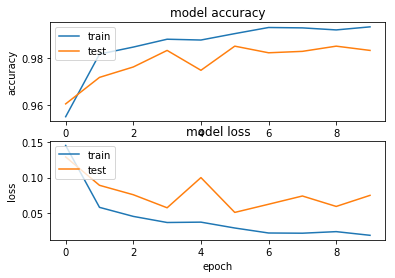

In [26]:
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

In [28]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [29]:
test_generator = test_datagen.flow_from_directory(
    directory="data/test",
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 21000 images belonging to 1 classes.


In [30]:
nb_test_samples = len(test_generator.filenames)

In [31]:
%%time
bottleneck_features_test = model_vgg16.predict_generator(test_generator)

CPU times: user 1min 46s, sys: 33.2 s, total: 2min 19s
Wall time: 1min 59s


In [32]:
bottleneck_features_test.shape

(21000, 4, 4, 512)

In [33]:
np.save('bottleneck_features_test.npy', bottleneck_features_test) 

In [34]:
test_data = np.load('bottleneck_features_test.npy') 

In [35]:
pred = model.predict(test_data)

In [36]:
pred.shape

(21000, 10)

In [37]:
predicted_class_indices=np.argmax(pred,axis=1)

In [38]:
predictions = list(predicted_class_indices)

In [39]:
filenames=test_generator.filenames

In [40]:
results=pd.DataFrame({"filename":filenames,
                      "label":predictions})
results.to_csv("results/results_vgg_bottleneck.csv",index=False)